## 데이터셋 및 로더 제작

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from utils.dataset import normalize_label
class PCOSDataset(Dataset):
    def __init__(self, df, data_root, filename_col, label_col, label_mapping,
                 transform=None, multi_label=False):
        
        self.df = df.reset_index(drop=True)
        self.data_root = data_root
        self.filename_col = filename_col
        self.label_col = label_col
        self.transform = transform
        self.label_mapping = label_mapping
        self.multi_label = multi_label

    def __len__(self):
        return len(self.df)

    def load_image(self, path):
        if not os.path.exists(path):
            print(f"[Warning] Image not found: {path} — skipping.")
            return Image.new("RGB", (224, 224), color=(0, 0, 0))  # 빈 이미지 반환
        
        return Image.open(path).convert("RGB")

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        filename = row[self.filename_col]
        img_path = os.path.join(self.data_root, filename)

        image = self.load_image(img_path)

        # augmentation 적용
        if self.transform:
            image = self.transform(image)

        # multi-label / multi-class 지원
        label = normalize_label(row[self.label_col])

        if self.multi_label:
            # multi-label: ['PCOS','NORMAL'] → multi-hot 벡터로 변환 등 확장 가능
            numeric_label = [self.label_mapping[l] for l in label]
        else:
            numeric_label = self.label_mapping[label]

        return image, numeric_label


### Transform

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd 
data_root_dir = "/workspace/pcos_dataset/Dataset"
label_path = "/workspace/pcos_dataset/labels/기존_Dataset_info.csv"
label_df = pd.read_csv(label_path)

# --- Transform 자동 적용 ---
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

### Train / Val / Test Hold-Out ValidationDataLoader

In [ ]:
from utils.dataset import create_label_mapping, create_weighted_sampler, stratified_split_by_pid

label_mapping = create_label_mapping(label_df, "label")

train_df, val_df, test_df = stratified_split_by_pid(label_df)

train_dataset = PCOSDataset(train_df, data_root_dir, "filename", "label", label_mapping, transform=train_tf)
val_dataset   = PCOSDataset(val_df,   data_root_dir, "filename", "label", label_mapping, transform=val_tf)
test_dataset  = PCOSDataset(test_df,  data_root_dir, "filename", "label", label_mapping, transform=val_tf)

sampler = create_weighted_sampler(train_df, "label")

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


### 5-Fold Cross Validation DataLoader

In [ ]:
from utils.dataset import create_label_mapping, create_weighted_sampler, stratified_pid_kfold
folds = stratified_pid_kfold(label_df, n_splits=5) # [ADD] K-Fold Cross Validation 추가
label_mapping = create_label_mapping(label_df, "label")

kfold_loaders = []

for fold_idx, (train_df, val_df) in enumerate(folds):
    train_dataset = PCOSDataset(train_df, data_root_dir, "filename", "label",
                                label_mapping, transform=train_tf)
    val_dataset   = PCOSDataset(val_df,   data_root_dir, "filename", "label",
                                label_mapping, transform=val_tf)

    sampler = create_weighted_sampler(train_df, "label")

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    kfold_loaders.append((train_loader, val_loader))

    print(f"Fold {fold_idx} loader ready.")


## Usage : Tune / Test : 8/2 => Tune -> 5-Fold Cross Validation(Train / Val : 7/1)

In [ ]:
import pandas as pd 
data_root_dir = "/workspace/pcos_dataset/Dataset"
label_path = "/workspace/pcos_dataset/labels/기존_Dataset_info.csv"
label_df = pd.read_csv(label_path)

In [ ]:
from utils.dataset import PCOSDataset, create_label_mapping, create_weighted_sampler, stratified_pid_kfold, stratified_split_by_pid
from utils.transform import get_transform, SpeckleNoise, AddGaussianNoise

from torch.utils.data import DataLoader
from torchvision import transforms

train_tf, val_tf = get_transform(
    train_transform=[
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.05,0.05), scale=(0.95,1.05)),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),

        # AddGaussianNoise(std=0.02),
        # SpeckleNoise(noise_factor=0.1),
    ]
)

label_mapping = create_label_mapping(label_df, "label")

# 2) Train / Val / Test split (PID 단위 stratified 7:1:2)
train_df, val_df, test_df = stratified_split_by_pid(label_df)

# 3) Tune = Train + Val (80%)
tune_df = pd.concat([train_df, val_df]).reset_index(drop=True)

# 4) K-Fold는 tune_df 에 대해서만 적용
folds = stratified_pid_kfold(tune_df, n_splits=5) # [ADD] K-Fold Cross Validation 추가
kfold_loaders = []

for fold_idx, (train_df, val_df) in enumerate(folds):
    train_dataset = PCOSDataset(train_df, data_root_dir, "filename", "label",
                                label_mapping, transform=train_tf)
    val_dataset   = PCOSDataset(val_df,   data_root_dir, "filename", "label",
                                label_mapping, transform=val_tf)

    sampler = create_weighted_sampler(train_df, "label")

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
    val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    kfold_loaders.append((train_loader, val_loader))

    print(f"Fold {fold_idx} loader ready.")

# Test loader는 따로 구성
test_dataset = PCOSDataset(test_df, data_root_dir, "filename", "label", label_mapping, transform=val_tf)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### Test 

In [ ]:
# 첫 번째 배치만 이미지 4장만 2x2로 label과 함께 시각화
import matplotlib.pyplot as plt
import torchvision
import json 

label_cls_dict = json.load(open("/workspace/pcos_dataset/label_mapping.json", "r"))
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 한 배치에서의 클래스 분포 확인
import collections
batch_class_counts = collections.Counter(labels.tolist())
print("Batch class distribution:", batch_class_counts)


### 배치 시각화

In [ ]:
# 3개 클래스이므로 1x3 배열로, 각 클래스(0,1,2)별 이미지를 하나씩 시각화
num_classes = 3
fig, axes = plt.subplots(1, num_classes, figsize=(12, 4))

# 인버스 normalize (미리 적용된 Normalize를 되돌림)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def inv_normalize(image):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

# 클래스별로 하나씩만 고르기 (없으면 빈 plot)
for class_idx in range(num_classes):
    ax = axes[class_idx]
    found = False
    for i in range(images.size(0)):
        if labels[i].item() == class_idx:
            
            # 이미지 정규화 처리
            # img = inv_normalize(images[i].cpu().clone()) # USE
            img = images[i].cpu().clone() # Unuse

            img = img.permute(1, 2, 0).numpy()
            ax.imshow(img)
            ax.axis('off')
            label_num = str(labels[i].item())
            label_str = label_cls_dict[label_num]
            ax.set_title(label_str)
            found = True
            break
    if not found:
        ax.axis('off')
        ax.set_title(f"Class {class_idx} 없음")

plt.suptitle("Each Class Example")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Multiple Instance Learning Dataset 제작

In [1]:
from utils.dataset import PCOSMILDataset, create_label_mapping, create_weighted_sampler, stratified_pid_kfold, stratified_split_by_pid
from utils.transform import get_transform, SpeckleNoise, AddGaussianNoise

from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd 
data_root_dir = "/workspace/pcos_dataset/Dataset"
label_path = "/workspace/pcos_dataset/labels/기존_Dataset_info.csv"
label_df = pd.read_csv(label_path)

train_tf, val_tf = get_transform(
    train_transform=[
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(10),
        # transforms.RandomAffine(degrees=0, translate=(0.05,0.05), scale=(0.95,1.05)),
        # transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),

        # AddGaussianNoise(std=0.02),
        # SpeckleNoise(noise_factor=0.1),
    ]
)

label_mapping = create_label_mapping(label_df, "label")

# 2) Train / Val / Test split (PID 단위 stratified 7:1:2)
train_df, val_df, test_df = stratified_split_by_pid(label_df)

# 3) Tune = Train + Val (80%)
tune_df = pd.concat([train_df, val_df]).reset_index(drop=True)

# 4) K-Fold는 tune_df 에 대해서만 적용
folds = stratified_pid_kfold(tune_df, n_splits=5) # [ADD] K-Fold Cross Validation 추가
kfold_loaders = []

for fold_idx, (train_df, val_df) in enumerate(folds):
    train_dataset = PCOSMILDataset(train_df, data_root_dir, transform = train_tf)
    val_dataset   = PCOSMILDataset(val_df,   data_root_dir, transform = val_tf)

    sampler = create_weighted_sampler(train_df, "label")

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=16)
    val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=16)

    kfold_loaders.append((train_loader, val_loader))

    print(f"Fold {fold_idx} loader ready.")

# Test loader는 따로 구성
test_dataset = PCOSMILDataset(test_df, data_root_dir, transform=val_tf)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=16)

Label Mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2}
PID Split Result:
Train: 2092 Val: 309 Test: 567
[Fold 0] Train: 1891, Val: 510
[Fold 1] Train: 1914, Val: 487
[Fold 2] Train: 1970, Val: 431
[Fold 3] Train: 1884, Val: 517
[Fold 4] Train: 1945, Val: 456
Fold 0 loader ready.
Fold 1 loader ready.
Fold 2 loader ready.
Fold 3 loader ready.
Fold 4 loader ready.


torch.Size([1, 6, 3, 224, 224])
tensor([1])


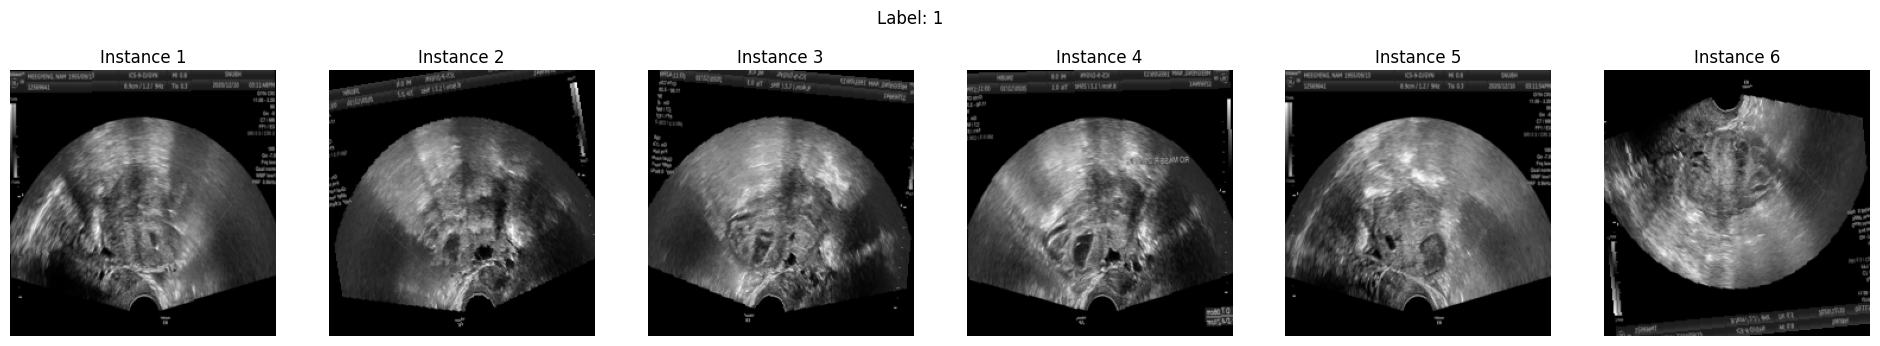

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Define mean and std for inverse normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def inv_normalize(image):
    # image: torch.Tensor, shape [C, H, W]
    image = image.clone()
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

images, labels = next(iter(train_loader))
print(images.shape)
print(labels)

# images: [batch, instance, channel, H, W]
batch_size, num_instances, c, h, w = images.shape

# Visualize all instances in the first bag (batch[0]) with inverse normalization
fig, axs = plt.subplots(1, num_instances, figsize=(4*num_instances, 4))
if num_instances == 1:
    axs = [axs] # Make it iterable

for i in range(num_instances):
    img = images[0, i]  # [c, h, w]
    img = inv_normalize(img)
    np_img = img.cpu().numpy()
    np_img = np.transpose(np_img, (1,2,0))  # [h, w, c]
    np_img = np.clip(np_img, 0, 1)
    axs[i].imshow(np_img)
    axs[i].set_title(f"Instance {i+1}")
    axs[i].axis('off')
plt.suptitle(f"Label: {labels.item()}")
plt.show()